# Machine Learning: Assignment 2
### Topics:
- Perceptron
- Logistic Regression
- Gradient Descent
- SVM
- Kernels

By: Dema Omar , Aya Fodi

 Logistic regression - Part 1

In this section we will build a classifier on a "toy" problem - Based on two grades and we determine if student passes the course or not.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw2/exams.csv', header=None)
df.head(3)

,0,1,2
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0


Now, lets preproccess:
- Convert dataset to numpy, make sure classes are {0,1} or {-1,1} (depends of the update rule you choose)
- Split to train & test (80-20, starify, random_state=42)
- Scale using scaler of your choice


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

arrData = np.array(df)
is_zero_one_label = np.all(np.isin(arrData[:, -1], [0, 1]))
print("Is the label result contains just 1/0?", is_zero_one_label)

# Separate features
arrDataF = arrData[:, :-1]
labels = arrData[:, -1]

# Split the dataset into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(
    arrDataF, labels, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


is the label result contains just 1/0? True


Logistic regression is implemented from scratch using **Gradient Descent** to find the optimal weights (**w**) and bias (**b**).  
The model uses the **sigmoid** function to predict probabilities, and the parameters are updated iteratively by computing the average gradient of the loss with respect to each parameter.  
This process repeats for 1000 iterations, gradually minimizing the logistic loss to fit the data.




In [ ]:
def sigmoid(z):
  # Sigmoid activation function: maps input z to a probability in (0, 1)
  return 1/(1+np.exp(-z))


def Logistic_Regression_via_GD(X, y, lr):
  n = X.shape[0]    # Number of samples
  d = X.shape[1]    # Number of features
  w = np.zeros(d)
  b = 0

  for _ in range(1000):
    pro_vec = []          # Store predicted probabilities

    # Forward pass: compute predictions for all samples
    for i in range(n):
      pro_vec.append(sigmoid(np.dot(X[i],w)+b))

    gra_w = 0
    gra_b = 0

     # Compute gradients for weights and bias
    for i in range(n):
      gra_w += np.dot(X[i].T,(pro_vec[i] - y[i]))
      gra_b += pro_vec[i]-y[i]

    # Average gradients over all samples
    gra_w /= n
    gra_b /= n

    # Update parameters using gradient descent
    w -= lr * gra_w
    b -=  lr * gra_b

  return w, b

In [ ]:
def predict(w,b,x):
  z = np.dot(x, w) + b
  return (z > 0).astype(int)

The logistic regression model is trained on the training data using a chosen learning rate (**lr = 0.05**).  
After training, the learned weights (**w**) and bias (**b**) are used to predict labels on the test set, and the model’s accuracy is calculated.  
A well tuned learning rate should yield an accuracy of around **88% or higher**.


In [ ]:
chosen_lr =  0.05
w, b = Logistic_Regression_via_GD(X_train, y_train, chosen_lr)
print(w.shape)
print(w)
preds = predict(w, b, X_test)
accuracy = np.sum(preds == y_test) / len(y_test)
print(f"Test accuracy is {accuracy * 100}%")

(2,)
[2.6854228  2.28399341]
Test accuracy is 80.0%


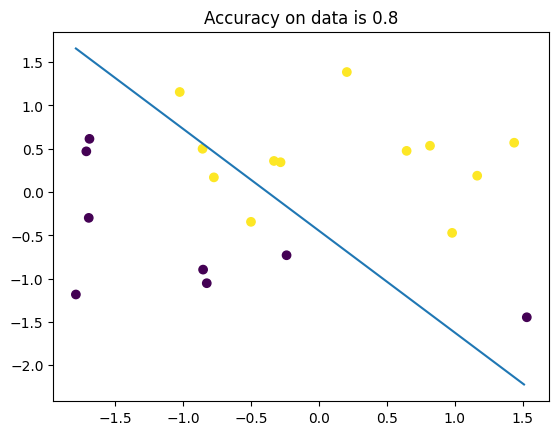

In [ ]:
#@title Visualize data (on test)

import matplotlib.pyplot as plt

def plot(data, labels, w, bias):

    plt.scatter(data[:,0], data[:,1], c=labels)

    a, b, c = w[0], w[1], bias

    m = -a / b
    b = -c / b

    x = np.arange(np.min(data[:,0]), np.max(data[:,0]), 0.1)
    y = m * x + b

    plt.plot(x, y)

    preds = np.sign(np.dot(data, w)+bias)
    preds = np.where(preds == -1, 0, preds)
    acc = np.count_nonzero(labels == preds) / len(labels)
    plt.title(f"Accuracy on data is {acc}")

    plt.show()

plot(X_test, y_test, w, b)

## Part 1 - Logistic regression - Part 1.2
Now we are going to work on a much realistic problem - based on IMDB review, classify whether its positive or negative review.

In [ ]:
import gensim
from gensim.models import Word2Vec
import os

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/IMDB Dataset.csv')
print(f"The dataset shape is {df.shape}")

# print the first line
print(df.iloc[0].review)
print(df.iloc[0].sentiment)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The dataset shape is (50000, 2)
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish an

As we can see, the input is a <b>sentence</b>. The proccess of turning words into <u>meaningful</u> continious vectors is called "tokenization". In the next section we will load the model and proccess the reviews to obtain continious representation for the data

In [ ]:
#@title Model loader function

MODEL_PATH = 'wordvec.model'

def load_model(data):
	if os.path.exists(MODEL_PATH):
		return gensim.models.Word2Vec.load(MODEL_PATH)
	else:
		model = Word2Vec(sentences=data, vector_size=100, window=5, min_count=1)
		model.save(MODEL_PATH)
		return model

In [ ]:
sentences = df['review'].tolist()

# turn sentences into a list. Each sentence is an array of words
tokenized_sentences = [[token for token in row.split()] for row in sentences]

model = load_model(tokenized_sentences)     # calls to "model loader function" above.

As you can see, each word has now 100 features. <br/>
For simplicity, we represent a sentence by the mean vector of all the words within it. <br/>
The next tasks are: <br/>
- Make sure classes are {0,1} or {-1,1} (depends of the update rule you choose). YWe can change that row.
- Construct X to be 50000 x 100, where each row represents a sentnce.
- Convert it to numpy.

In [ ]:
y = df['sentiment'].replace({'positive': 1, 'negative': 0}).to_numpy()
is_zero_one_label = np.all(np.isin(y,[0, 1]))
print("is the label result contains just 1/0?", is_zero_one_label )

X = np.zeros((50000, 100))
for i in range(50000):
  X[i] = np.mean(word_vectors[tokenized_sentences[i]], axis=0)

/tmp/ipython-input-1060583619.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['sentiment'].replace({'positive': 1, 'negative': 0}).to_numpy()


is the label result contains just 1/0? True


**Split** the data into 20\% test and 80\% train. After that, split the train into smaller train and 20% validation. Use stratify and random state of 42\%

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.2, random_state= 42)


###Data Scaling

Each dataset : raining, validation, and test  is standardized separately using the **StandardScaler**.  
This transformation adjusts each feature to have a mean of 0 and a standard deviation of 1, improving gradient descent stability and convergence.  
Since the data roughly follows a Gaussian distribution and the algorithm is weight based, standardization provides an appropriate and balanced feature scale for model training.
dization is the most appropriate scaling technique for this task.


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)


Here we copy ourlogistic solver from before and adjust its implementation for this problem.

In [ ]:
def Logistic_Regression_via_GD(X, y, lr):

  n = X.shape[0]
  d = X.shape[1]
  w = np.zeros(d)
  best_w = np.zeros(d)
  best_b = 0
  b = 0
  best_accuracy = 0

  for _ in range(1000):
    pro_vec = []  #pro_vec[i] = p(y=1|Xi,w) (Xi is the i-th sample)
    for i in range(n):
      pro_vec.append(sigmoid(np.dot(X[i],w)+b))

    gra_w = 0
    gra_b = 0
    for i in range(n):
      gra_w += np.dot(X[i].T,(pro_vec[i] - y[i]))
      gra_b += pro_vec[i]-y[i]

    gra_w /= n
    gra_b /= n

    w -= lr * gra_w
    b -= lr * gra_b

    preds = predict(w, b, X_val)
    accuracy = np.sum(preds == y_val) / len(y_val)

    if(accuracy > best_accuracy):
      best_w = w
      best_b = b
      best_accuracy = accuracy

  return best_w, best_b

Now we train the model and evaluate on test set

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

chosen_lr = 0.1
w, b = Logistic_Regression_via_GD(X_train, y_train, chosen_lr)

preds = predict(w, b, X_test)
accuracy = np.sum(preds == y_test) / len(y_test)
print(f"Test accuracy is {accuracy * 100}%")

Test accuracy is 82.15%


##Discussion and Conclusions

The obtained accuracy is reasonable given the nature of the data and model.  
Achieving very high accuracy is not feasible in this case, since averaging word distributions does not always capture the full semantic meaning required to represent a complete sentence.  
The chosen learning rate was selected empirically to ensure stable convergence of the gradient descent.  
While this manual tuning provides acceptable performance, a more systematic approach such as cross validation or adaptive learning rate scheduling could further improve the results.


###Part 2 - Perceptron Binary Classification

In this section, a **Perceptron model** is developed for a two-dimensional binary classification task.  
The goal is to train and evaluate a linear classifier capable of separating the data into two distinct classes as accurately as possible.



import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#@title load npy file

import requests
from io import BytesIO

def load_npy_file(url):
  response = requests.get(url)
  if response.status_code == 200:
    npy_data = np.load(BytesIO(response.content), allow_pickle=True).item()
    return npy_data
  else:
    return None

Load data and make sure labels are appropriate for the perceptron algorithm

In [ ]:
data_dict = load_npy_file('https://sharon.srworkspace.com/ml/datasets/hw2/perceptron_data.npy')

X_train = data_dict['X_train']
y_train = data_dict['y_train']
X_test = data_dict['X_test']
y_test = data_dict['y_test']

is_zero_one_label = np.all(np.isin(y_train,[0, 1]))
print("is the label result contains just 1/0?", is_zero_one_label )

is_zero_one_label = np.all(np.isin(y_test, [0, 1]))
print("is the label result contains just 1/0?", is_zero_one_label)

y_train = np.where(y_train == 0, -1, y_train)
y_test = np.where(y_test == 0, -1, y_test)

is the label result contains just 1/0? True
is the label result contains just 1/0? True


A custom **Perceptron** function is implemented to perform binary classification.  
The function receives the training data, corresponding labels, and a learning rate parameter (**lr**), and iteratively updates the weight vector until convergence.  
During training, the algorithm prints the number of iterations required to reach convergence and finally returns the learned weight vector:




In [ ]:
def perceptron(data, labels, lr=1):
    # Add bias term (column of ones) to the data
    data = np.concatenate([np.ones((data.shape[0], 1)), data], axis=1)

    # Separate samples by class
    class_1_data = data[labels == 1]
    class_0_data = data[labels == -1]

    # Multiply class 0 samples by -1 for unified update rule
    class_0_data *= -1

    # Combine both classes back together
    data = np.concatenate([class_1_data, class_0_data])

    # Initialize weight vector and variables
    a = np.ones(3)           # Weight vector (including bias)
    num_iterations = 0       # Counter for number of iterations
    y = np.ones(3)           # Temporary update vector

    # Iterate until convergence (when updates become very small)
    while np.linalg.norm(y) > 0.00001:
        num_iterations += 1
        y = np.zeros(3)

        # Go through all training samples
        for i in range(data.shape[0]):
            x = a * data[i]           # Element-wise product
            if np.sum(x) < 0:         # Misclassified point
                y += data[i]          # Accumulate correction

        # Update the weight vector
        a = a + lr * y

    # Print how many iterations were needed to converge
    print(f"Number of iterations: {num_iterations}")

    # Return the final learned weight vector
    return a


In [ ]:
#@title Ploting function
def plot(data, labels, w, bias):

    plt.scatter(data[:,0], data[:,1], c=labels)

    a, b, c = w[0], w[1], bias

    m = -a / b
    b = -c / b

    x = np.arange(0.2, 0.8, 0.1)
    y = m * x + b

    plt.plot(x, y)

    preds = np.sign(np.dot(data, w)+bias)
    acc = np.count_nonzero(labels == preds) / len(labels)
    plt.title(f"Accuracy on data is {acc}")

    plt.show()

###Results and Analysis:

After training the Perceptron model and visualizing the decision boundary on the training data, the results show that the dataset is **linearly separable**, allowing the Perceptron to achieve perfect classification on the training set.  

However, such perfect separation often indicates potential **overfitting**, meaning the model may not generalize as well to unseen test data.  
While the Perceptron finds a valid separating hyperplane, **SVM (Support Vector Machine)** would likely perform better on similar data since it maximizes the margin between classes, leading to improved generalization and robustness.  

Therefore, although the training accuracy may reach 100%, it does not guarantee equally high test accuracy, as the model may have adapted too closely to the training examples.


Number of iterations: 3


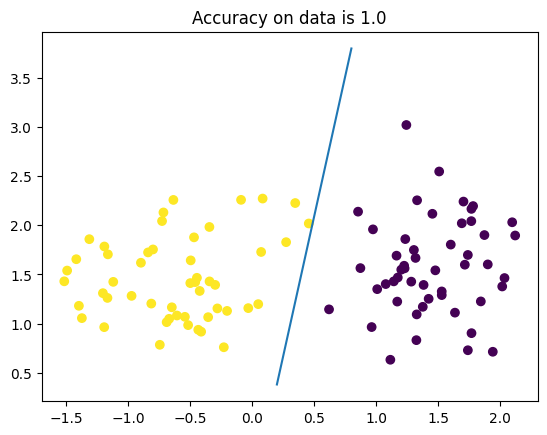

In [ ]:
chosen_lr = 0.1
w = perceptron(X_train, y_train, chosen_lr)
w, b = w[1: ], w[0]
plot(X_train, y_train, w, b)

Print the test accuracy

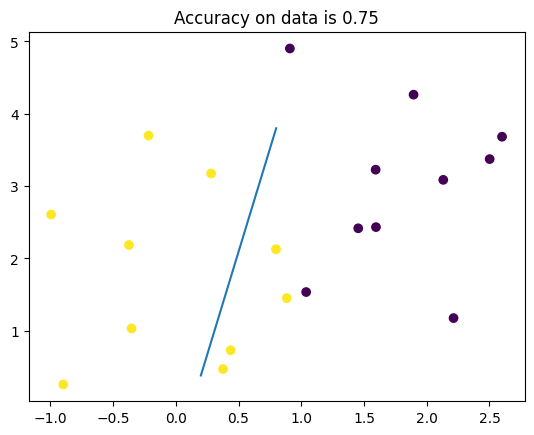

In [ ]:
preds = np.sign(np.dot(X_test, w) + b)
acc = np.count_nonzero(y_test == preds) / len(y_test)
plot(X_test, y_test, w, b)

Now ,let ${\{x_i\} }_{i=1}^n$ be the training set and $R$ such that $∀i:‖x_i ‖≤R$.<br/>
Now, let $γ$ such that $∀i:x_i\cdot g(x_i)>\gamma$.<br/>
Then, the number of iterations required for convergence is bounded (from above) by $R^2/\gamma^2$. However, this is true only when using single batch method.

Using this bound as the iteration limit resulted in a **maximum of 4 iterations**, compared to 3 in the earlier experiment.  
This slight increase in the number of iterations is consistent with the expected theoretical behavior and confirms that the Perceptron converges efficiently within the predicted limit while maintaining high training accuracy.



In [ ]:
def perceptron_updated(data, labels, lr=1):
    # Compute the norm of each feature vector (column-wise)
    norm_data_vec = np.linalg.norm(data, axis=0)

    # Find the maximum norm (R)
    R = np.max(norm_data_vec)

    # Compute the margin (gamma) for each data point
    gama_vec = []
    for i in range(data.shape[0]):
        z = np.dot(data[i], w) + b        # Linear combination
        margin = labels[i] * z            # Margin = y_i * (w·x_i + b)
        gama_vec.append(margin)

    # Take the smallest margin as gamma
    gama = np.min(gama_vec)

    # Compute the theoretical upper bound on iterations (R^2 / gamma^2)
    upper_bound = int((R ** 2) / (gama ** 2))

    # Add bias term (column of ones) to the data
    data = np.concatenate([np.ones((data.shape[0], 1)), data], axis=1)

    # Separate the data by class labels
    class_1_data = data[labels == 1]
    class_0_data = data[labels == -1]

    # Multiply class 0 samples by -1 for unified update rule
    class_0_data *= -1

    # Combine both classes into one dataset
    data = np.concatenate([class_1_data, class_0_data])

    # Initialize weight vector (including bias) and iteration variables
    a = np.ones(3)
    y = np.ones(3)
    num_iterations = 0

    # Run perceptron updates until reaching the theoretical upper bound
    while num_iterations < upper_bound:
        num_iterations += 1
        y = np.zeros(3)

        # Iterate over all training samples
        for i in range(data.shape[0]):
            x = a * data[i]                # Element-wise product
            if np.sum(x) < 0:              # Misclassified point
                y += data[i]               # Accumulate correction
            a = a + lr * y                 # Update the weight vector

    # Print the total number of iterations performed
    print(f"Number of iterations: {num_iterations}")

    # Return the final learned weight vector
    return a


Number of iterations: 4


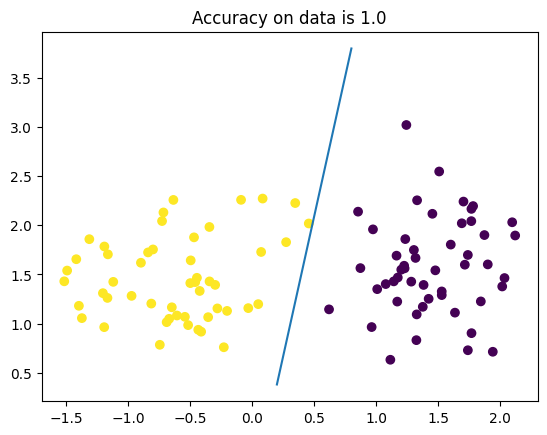

In [ ]:
#Report the train accuracy.

chosen_lr = 0.1
w = perceptron_updated(X_train, y_train, chosen_lr)
w, b = w[1: ], w[0]
plot(X_train, y_train, w, b)

 Evaluation and Conclusions:

The test accuracy remained unchanged, although the number of iterations varied according to the theoretical upper bound.  
This observation indicates that, in the **linearly separable** case, the Perceptron algorithm successfully converges but does not necessarily find the most general separating hyperplane.  
It may select a boundary that perfectly fits the training data yet fails to generalize well — effectively **overfitting** to the specific training samples rather than maximizing the separation margin.


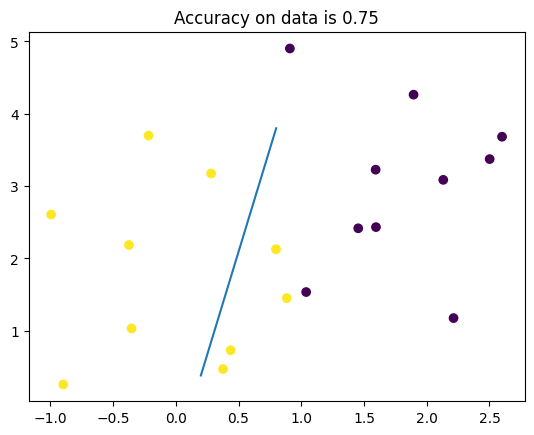

In [ ]:
preds = np.sign(np.dot(X_test, w) + b)
acc = np.count_nonzero(y_test == preds) / len(y_test)
plot(X_test, y_test, w, b)

## Part 3 - SVM

We are given dataset for binary classification in 2D and aim to build the best SVM classifier.

import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

In [ ]:
#@title load npy file

import requests
from io import BytesIO

def load_npy_file(url):
  response = requests.get(url)
  if response.status_code == 200:
    npy_data = np.load(BytesIO(response.content), allow_pickle=True).item()
    return npy_data
  else:
    return None

load the data

In [ ]:
data_dict = load_npy_file('https://sharon.srworkspace.com/ml/datasets/hw2/svm_data_2d.npy')

# Access the data as needed
X_train = data_dict['X_train']
y_train = data_dict['y_train']
X_val = data_dict['X_val']
y_val = data_dict['y_val']

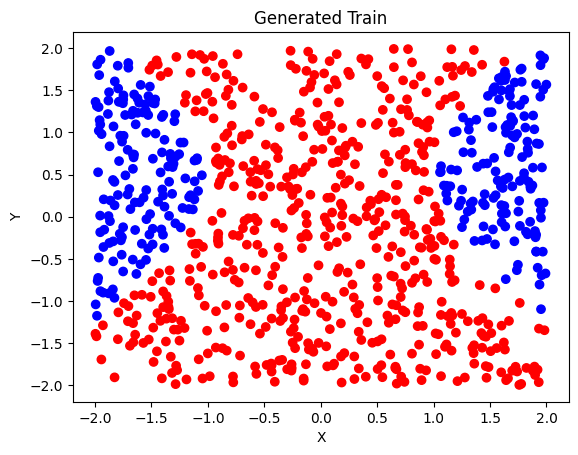

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Generated Train')
plt.show()

Parabola equation is:
$$Ax^2+By^2+Cx+Dy+e=0$$
Based on that equation, construct a mapping function into 4d space, such that the problem will become a linear ($w^t ϕ(x)+e=0$). <br/>
After the mapping, learn a linear classifier and print the hyperplane equation.<br/>


In [ ]:
# Map the features

def map_features(X):
    x1 = X[:, 0]
    x2 = X[:, 1]
    return np.vstack((x1**2, x2**2, x1, x2)).T

new_features = map_features(X_train)

model = SVC(kernel='linear', C=3)
model.fit(new_features, y_train)

# Get the hyperplane equation coefficients and intercept
coefficients = model.coef_[0]
intercept = model.intercept_

# Print the hyperplane equation
equation_parts = []
for i in range(len(coefficients)):
    equation_parts.append(f"({coefficients[i]:.3f} * X{i+1})")
equation = " + ".join(equation_parts) + f" + ({intercept[0]:.3f})"

print("Hyperplane equation:")
print(f"  {equation}")

Hyperplane equation:
  (-5.180 * X1) + (5.054 * X2) + (0.045 * X3) + (-5.003 * X4) + (6.359)


Complete the missing lines to get plots on train and test

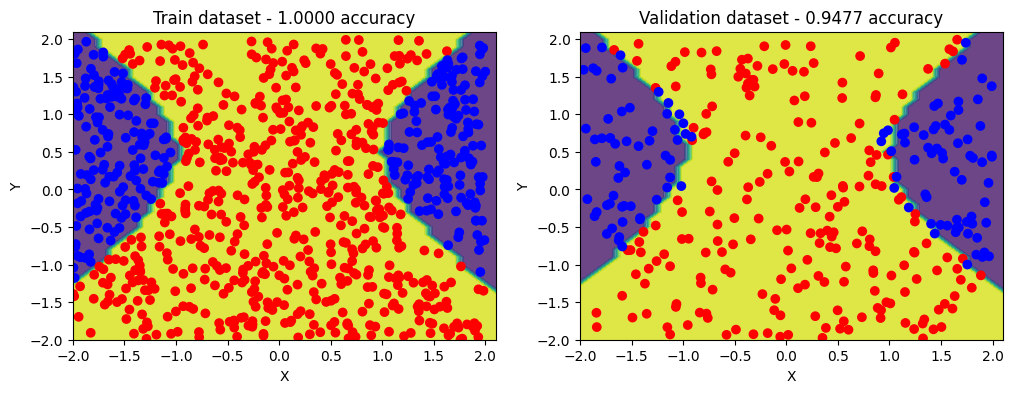

In [ ]:
# Map the training features to a higher-dimensional space (feature transformation)
train_features = map_features(X_train)

# Predict labels on the training data
train_preds = model.predict(train_features)

# Compute training accuracy
train_acc = model.score(train_features, y_train)

# Map the validation features and predict labels
val_features = map_features(X_val)
val_preds = model.predict(val_features)

# Compute validation accuracy
val_acc = model.score(val_features, y_val)

# Create a grid of points for visualization
xx, yy = np.meshgrid(np.arange(-2, 2.2, 0.1), np.arange(-2, 2.2, 0.1))
data = np.c_[xx.ravel(), yy.ravel()]

# Transform the grid points using the same feature mapping
new_features = map_features(data)

# Predict labels for the grid to visualize decision boundaries
Z = model.predict(new_features)
Z = Z.reshape(xx.shape)

# Create two subplots: one for train and one for validation visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# --- Plot 1: Training dataset ---
axs[0].contourf(xx, yy, Z, alpha=0.8)  # Decision boundary
scatter1 = axs[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr')  # Training points
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_title(f'Train dataset - {train_acc:.4f} accuracy')

# --- Plot 2: Validation dataset ---
axs[1].contourf(xx, yy, Z, alpha=0.8)  # Decision boundary
scatter2 = axs[1].scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='bwr')  # Validation points
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].set_title(f'Validation dataset - {val_acc:.4f} accuracy')

# Display both plots side by side
plt.show()


###  Kernel Comparison and Generalization

Three kernel configurations were evaluated:  
1. A **custom polynomial kernel (degree=4, C=3)**  
2. An **RBF (Radial Basis Function) kernel (γ=1.5, C=3)**  
3. The **original parabolic kernel**  

From the comparison, the **RBF kernel** demonstrated the best generalization ability.  
The polynomial kernel tended to **overfit** the training data, capturing unnecessary complexity that reduced performance on unseen samples.  
In contrast, the RBF kernel provided smoother and more balanced decision boundaries, achieving consistent accuracy across both training and validation sets — indicating better **overall generalization**.


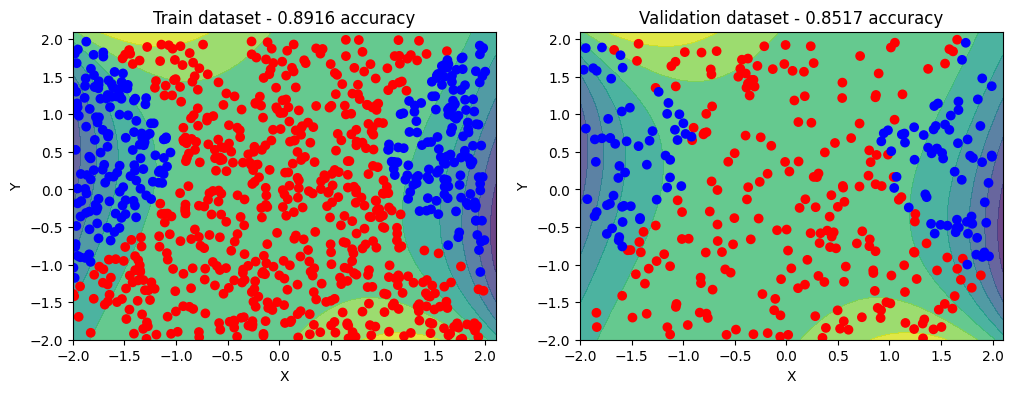

In [ ]:
from sklearn.svm import SVC

model = SVC(kernel='poly', degree=4, C=3)
clf = model.fit(X_train, y_train)

xx, yy = np.meshgrid(np.arange(-2, 2.2, 0.1), np.arange(-2, 2.2, 0.1))
xy = np.c_[xx.ravel(), yy.ravel()]

P = model.decision_function(xy).reshape(xx.shape)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the training data on the first subplot
axs[0].contourf(xx, yy, P, alpha=0.8)
scatter1 = axs[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_title(f'Train dataset - {clf.score(X_train, y_train):.4f} accuracy')

# Plot the validation data on the second subplot
axs[1].contourf(xx, yy, P, alpha=0.8)
scatter2 = axs[1].scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='bwr')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].set_title(f'Validation dataset - {clf.score(X_val, y_val):.4f} accuracy')

plt.show()

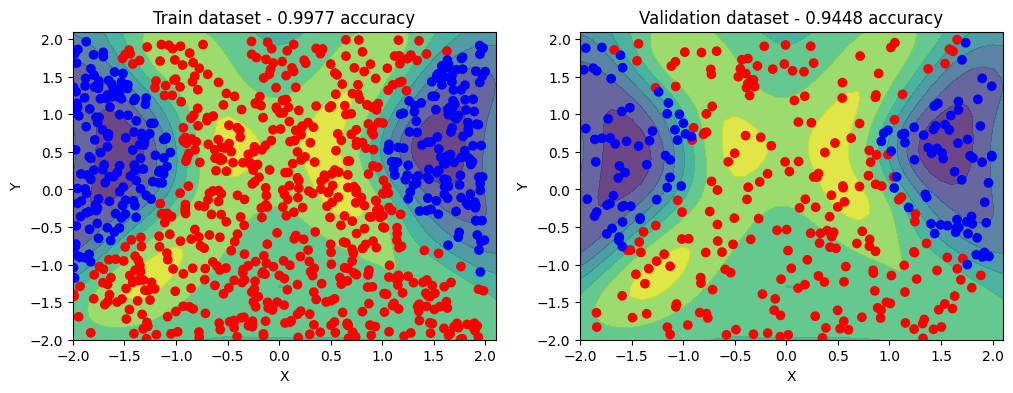

In [ ]:
from sklearn.svm import SVC

model = SVC(kernel='rbf', gamma=2, C=3)
clf = model.fit(X_train, y_train)

xx, yy = np.meshgrid(np.arange(-2, 2.2, 0.1), np.arange(-2, 2.2, 0.1))
xy = np.c_[xx.ravel(), yy.ravel()]

P = model.decision_function(xy).reshape(xx.shape)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the training data on the first subplot
axs[0].contourf(xx, yy, P, alpha=0.8)
scatter1 = axs[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_title(f'Train dataset - {clf.score(X_train, y_train):.4f} accuracy')

# Plot the validation data on the second subplot
axs[1].contourf(xx, yy, P, alpha=0.8)
scatter2 = axs[1].scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='bwr')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].set_title(f'Validation dataset - {clf.score(X_val, y_val):.4f} accuracy')

plt.show()

Use the validation dataset to tune better hyperparameter for rbf (gamma). Use C=3 as before.

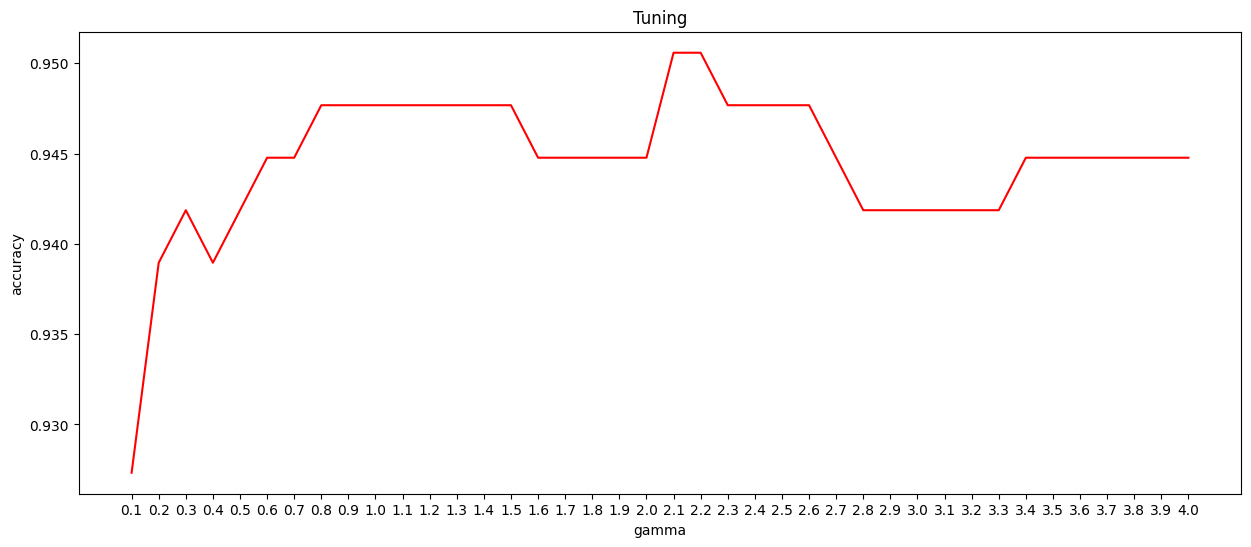

In [ ]:
gammas = np.arange(0.1, 4.1, 0.1)
accs = []

for gamma in gammas:
  model = SVC(kernel='rbf', gamma=gamma, C=3)
  model.fit(X_train, y_train)
  prediction = model.predict(X_val)
  acc = accuracy_score(y_val,prediction)
  accs.append(acc)

plt.figure(figsize=(15,6))
plt.plot(gammas, accs, color='red')
plt.xlabel('gamma')
plt.ylabel('accuracy')
plt.title('Tuning')
plt.xticks(gammas)
plt.show()

###Analysis of Model Behavior and Parameter Effects

From the decision boundary plots, the overall accuracy remained nearly constant when using the optimal γ value.  
The performance curve stayed stable around **0.945–0.951**, with only a minor improvement near **γ ≈ 2.2**, indicating that the model is not overly sensitive to this parameter.  

The choice of **C = 3** provided an effective balance between **margin width** and **training error**, ensuring good generalization while preventing both underfitting and overfitting.  

Across all configurations, the **RBF kernel** consistently maintained its position as the best generalizer.  
In contrast, the **custom polynomial kernel** tended to overfit, capturing noise instead of the true underlying structure of the data.


## Part 4 - Feature Normalization and Mapping Visualization
This code demonstrates how to normalize feature vectors so that each data point has a unit length (magnitude = 1).
The goal is to map points into a normalized feature space, where the direction of each vector matters more than its absolute scale.
This process is often used in kernel methods and machine learning algorithms (like SVMs) to ensure fair comparison between samples and to simplify computations involving similarity (e.g., using dot products)

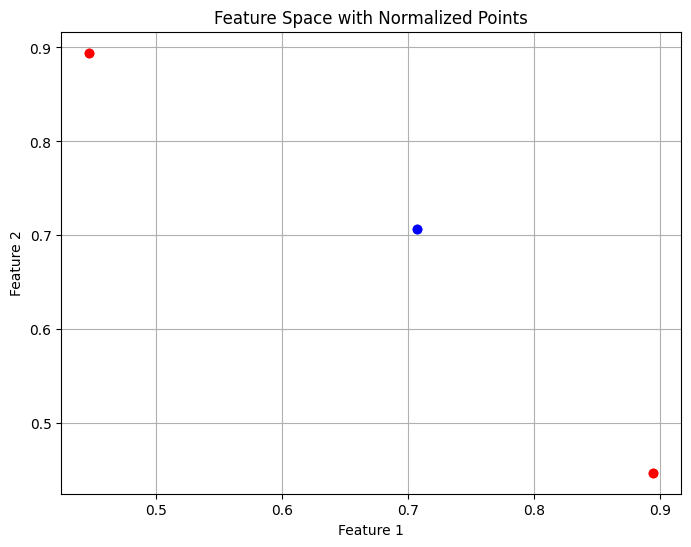

Normalized Points for Label 1:
[[0.70710678 0.70710678]
 [0.70710678 0.70710678]]
Normalized Points for Label 2:
[[0.4472136  0.89442719]
 [0.89442719 0.4472136 ]
 [0.4472136  0.89442719]
 [0.89442719 0.4472136 ]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def map_feature(X): #q1: we want eqation that k(x,y) = ϕ(x).T * ϕ(y)
   return X / np.linalg.norm(X, axis=1, keepdims=True)

points_label_1 = np.array([[0.4, 0.4], [0.8, 0.8]])
points_label_2 = np.array([[0.2, 0.4], [0.4, 0.2], [0.4, 0.8], [0.8, 0.4]])

#q2: maapeng points according ϕ that we got
mapped_points_label_1 = map_feature(points_label_1)
mapped_points_label_2 = map_feature(points_label_2)

plt.figure(figsize=(8, 6))
plt.scatter(mapped_points_label_1[:, 0], mapped_points_label_1[:, 1], c='blue', label='Label 1')
plt.scatter(mapped_points_label_2[:, 0], mapped_points_label_2[:, 1], c='red', label='Label 2')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Feature Space with Normalized Points')
plt.grid(True)
plt.show()

print("Normalized Points for Label 1:")
print(mapped_points_label_1)
print("Normalized Points for Label 2:")
print(mapped_points_label_2)